# 코스피, 코스닥, 환율 데이터 수집 및 분석

# 데이터 분석
1. 계획 수립
2. 데이터 수집 (request)
3. 데이터 처리 (pandas)
4. 데이터 분석 (pandas, sklearn)
5. 레포팅, 피드백 (matplotlib)

### 네이버 증권 사이트에서 주가 데이터 수집

- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [91]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests

%config InlineBackend.figure_formats={'png','retina'}
import matplotlib.pyplot as plt
import seaborn as sns

##### 1. 웹 서비스 분석 : url

In [92]:
page, pagesize = 1, 20
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={pagesize}&page={page}'
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=20&page=1'

<!-- ![네이버 코스피 일별 데이터](./img/naver_daily_stock.png) -->

<img src="./img/naver_daily_stock.png" height="30%" width="30%">

#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [93]:
response = requests.get(url)
response

<Response [200]>

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [94]:
data = response.json()

In [95]:
kospi_df = pd.DataFrame(data)[['localTradedAt','closePrice']]
kospi_df.tail(2)

,localTradedAt,closePrice
18,2023-07-28,"2,608.32"
19,2023-07-27,"2,603.81"


#### 4. 함수로 만들기

1. 웹서비스 분석  : URL
2. request(URL) > response(JSON(str))
3. JSON(str) > list, dict > DataFrame

In [96]:
def stock_crawling(code='KOSPI', page=1, pagesize=60):
    
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={pagesize}&page={page}'
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data)[['localTradedAt','closePrice']]

In [97]:
kospi_df = stock_crawling()
kospi_df.tail(2)

,localTradedAt,closePrice
58,2023-06-01,"2,569.17"
59,2023-05-31,"2,577.12"


In [98]:
kosdaq_df = stock_crawling(code='KOSDAQ', page=1, pagesize=60)
kosdaq_df.tail(2)

,localTradedAt,closePrice
58,2023-06-01,863.78
59,2023-05-31,856.94


### 원달러 환율 데이터 수집 : 실습

1. 웹서비스 분석  : URL
2. request(URL) > response(JSON(str))
3. JSON(str) > list, dict > DataFrame

In [99]:

page, pagesize = 1, 60

url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&reutersCode=FX_USDKRW&pageSize={pagesize}'

response = requests.get(url)
data = response.json()['result']

usd_df = pd.DataFrame(data)
usd_df = usd_df[['localTradedAt', 'closePrice']]

In [100]:
usd_df.tail(2)

,localTradedAt,closePrice
58,2023-06-01,"1,320.00"
59,2023-05-31,"1,328.00"


### 데이터 분석

코스피, 코스닥, 원달러 환율의 상관분석  
  
가설 : 코스피가 높으면 원달러 환율은 낮고, 코스피가 낮으면 원달러 환율은 높다.  
- 가설이 맞을 경우  
    - 환율이 낮으면 달러를 산다.  
    - 환율이 높으면 달러를 팔아 코스피를 산다.  
    

#### 전처리

- DATE, KOSPI, KOSDAQ, USD 컬럼이 있는 데이터 프레임으로 변경 -> df
- 시각화를 위해서 데이터의 자료형을 실수형으로 변경
- 불필요한 글자 삭제

In [101]:
df = kospi_df.copy()
df.columns = ['date','kospi'] # kospi 데이터 
df['kosdaq'] = kosdaq_df['closePrice'] # kosdaq 데이터
df['usd'] = usd_df['closePrice'] # usd 데이터

df.tail(2)

,date,kospi,kosdaq,usd
58,2023-06-01,"2,569.17",863.78,"1,320.00"
59,2023-05-31,"2,577.12",856.94,"1,328.00"


In [102]:
df.dtypes # 모두 object이므로, float형 타입으로 변환

date      object
kospi     object
kosdaq    object
usd       object
dtype: object

In [103]:
df['kospi'] = df['kospi'].apply(lambda data: float(data.replace(",","")))
df['kosdaq'] = df['kosdaq'].apply(lambda data: float(data.replace(",","")))
df['usd'] = df['usd'].apply(lambda data: float(data.replace(",","")))

In [104]:
df.dtypes

date       object
kospi     float64
kosdaq    float64
usd       float64
dtype: object

#### 시각화

In [105]:
df['date'][::5]

0     2023-08-24
5     2023-08-17
10    2023-08-09
15    2023-08-02
20    2023-07-26
25    2023-07-19
30    2023-07-12
35    2023-07-05
40    2023-06-28
45    2023-06-21
50    2023-06-14
55    2023-06-07
Name: date, dtype: object

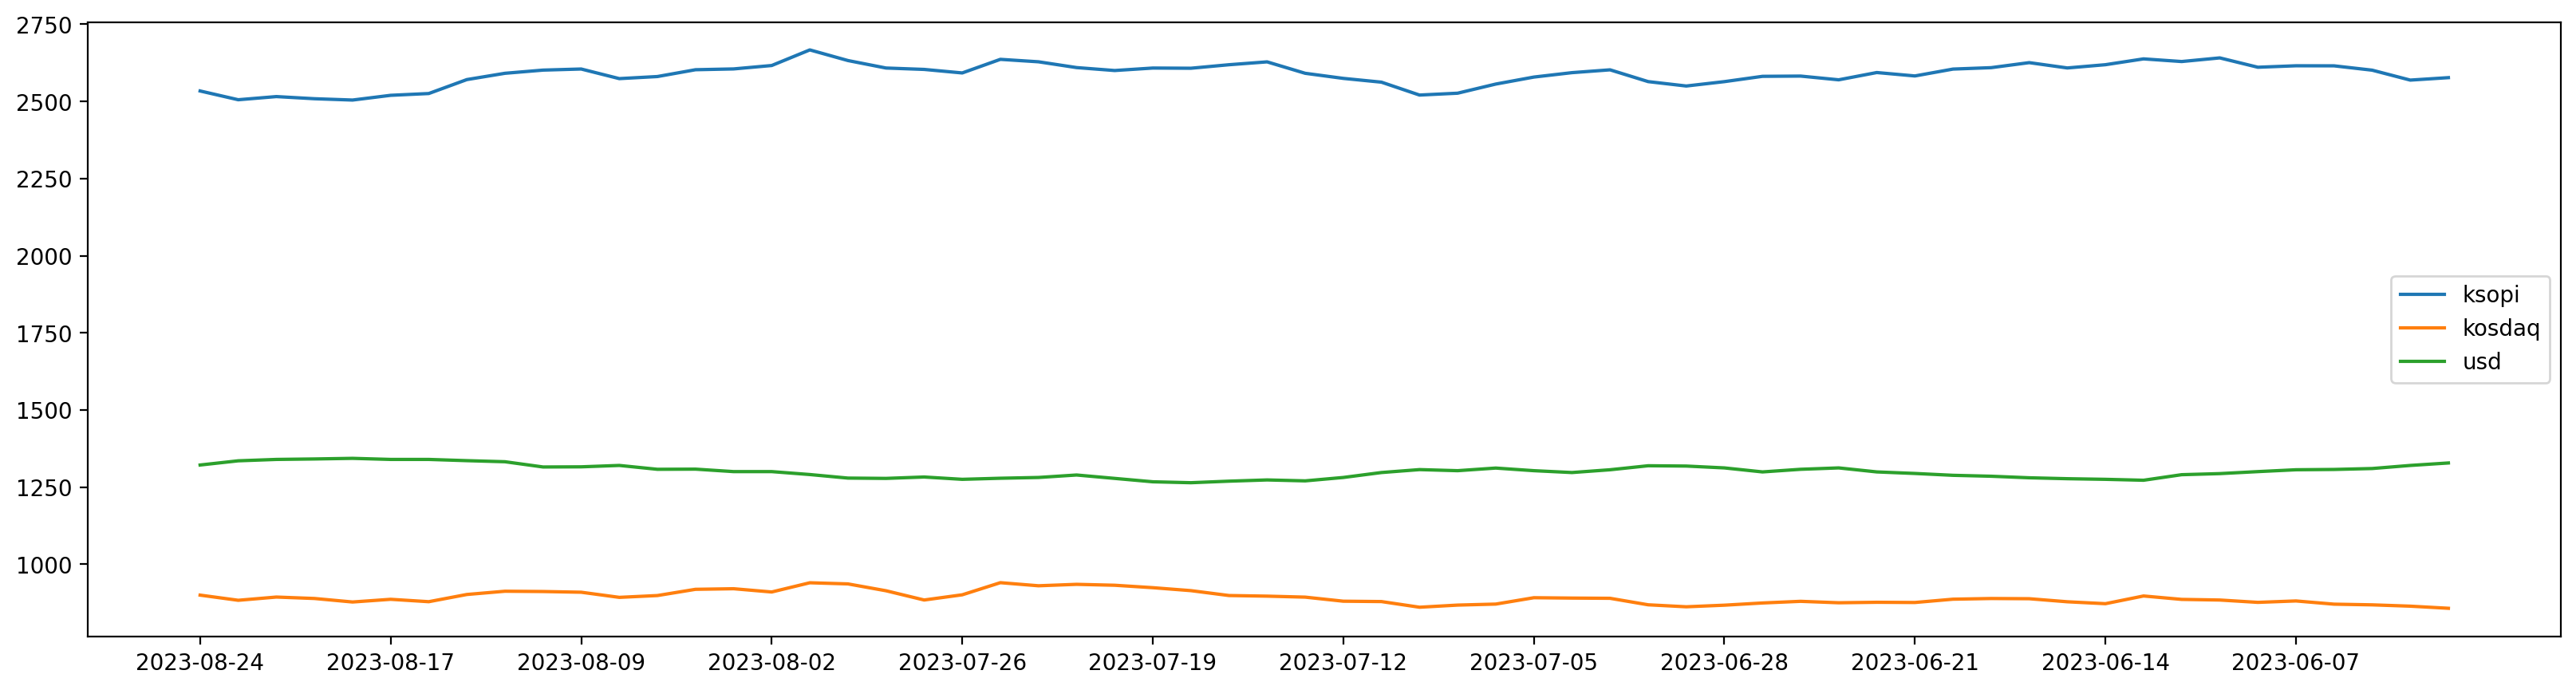

In [106]:
plt.figure(figsize=(20,5))
plt.plot(df['date'], df['kospi'], label='ksopi')
plt.plot(df['date'], df['kosdaq'], label='kosdaq')
plt.plot(df['date'], df['usd'], label='usd')

plt.xticks(df['date'][::5])
plt.legend()
plt.show()

위의 경우 각 열에 데이터 편차가 크기 때문에, 데이터 스케일링을 통해 그래프를 보기 편하게 해주도록 한다.

#### 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [107]:
from sklearn.preprocessing import minmax_scale
minmax_scale(df['kospi'])

array([0.18102971, 0.0061512 , 0.06913945, 0.02645014, 0.        ,
       0.09442086, 0.13003629, 0.40825491, 0.5336778 , 0.59703512,
       0.61893338, 0.42738513, 0.46878268, 0.60466261, 0.62059421,
       0.68874946, 1.        , 0.78784524, 0.63861721, 0.61087532,
       0.54044412, 0.81171188, 0.76293289, 0.64747493, 0.58885403,
       0.63812512, 0.63431137, 0.70431199, 0.76151812, 0.53349326,
       0.43193701, 0.35670788, 0.09964938, 0.13661807, 0.31857046,
       0.45826413, 0.54628775, 0.60263271, 0.36771852, 0.28000246,
       0.36716491, 0.47296549, 0.47794796, 0.40351848, 0.54868672,
       0.48059298, 0.61764163, 0.64587562, 0.74607861, 0.63997047,
       0.70480408, 0.82087716, 0.76797687, 0.8406225 , 0.65417974,
       0.68339792, 0.68222919, 0.59580488, 0.39779787, 0.44669988])

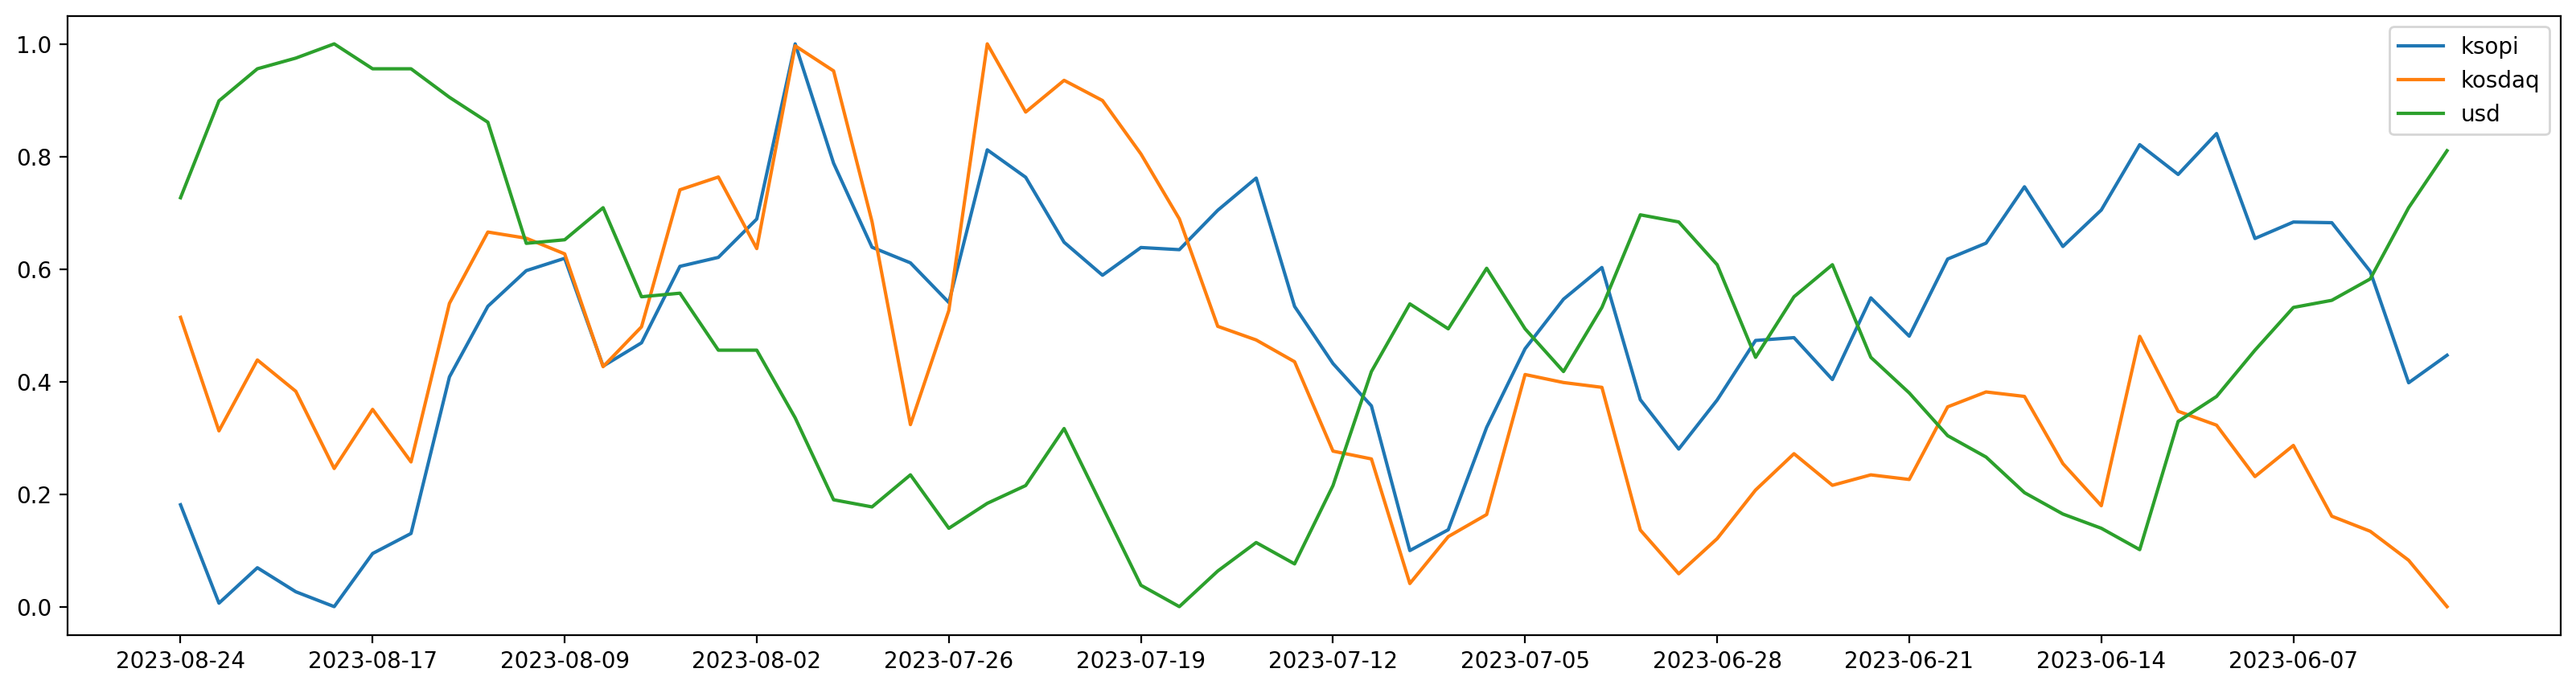

In [108]:
plt.figure(figsize=(20,5))
plt.plot(df['date'], minmax_scale(df['kospi']), label='ksopi')
plt.plot(df['date'], minmax_scale(df['kosdaq']), label='kosdaq')
plt.plot(df['date'], minmax_scale(df['usd']), label='usd')

plt.xticks(df['date'][::5])
plt.legend()
plt.show()

#### 상관관계 분석

- 피어슨 상관계수
    - -1에 가까울수록 서로 반대 방향으로 움직임
    - 1에 가까울수록 서로 같은 방향으로 움직음
    - 0에 가까울수록 두 데이터는 관계가 없음

In [109]:
df.corr()

,kospi,kosdaq,usd
kospi,1.000000,0.481062,-0.727936
kosdaq,0.481062,1.000000,-0.358716
usd,-0.727936,-0.358716,1.000000


위 상관관계 표를 보면,    
kospi와 kosdaq은 어느정도 같은 방향으로 움직이지만,  
kospi와 usd는 완전히 반대로 움직이는 것을 확인할 수 있다.  

##### 결론
가설대로,  
- 환율이 낮으면 달러를 산다.  
- 환율이 높으면 달러를 팔아 코스피를 산다.  
    